<a href="https://colab.research.google.com/github/M4deN/Mineracao-Dados/blob/main/Aula_02_Pre_Processamento.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Disciplina de Mineração de Dados
## Programa de Pós-graduação em Informática (PPGI)


# Encontro 2: Pré-processamento e Transformação de Dados

**Objetivos:**
- Compreender a importância do pré-processamento de dados.
- Aprender e aplicar técnicas de limpeza de dados (tratamento de dados ausentes, ruidosos e outliers).
- Aprender e aplicar técnicas de integração e transformação de dados (normalização, discretização, feature engineering).
- Aprender e aplicar técnicas de redução de dados (seleção de atributos e PCA).

## Setup Inicial

Importar as bibliotecas necessárias.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Módulos do Scikit-learn para pré-processamento
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, MinMaxScaler, KBinsDiscretizer, OneHotEncoder
from sklearn.decomposition import PCA
from sklearn.feature_selection import VarianceThreshold, SelectKBest, chi2, f_classif
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Configurações para melhor visualização
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (10, 6)

## 1. Carregando o Dataset

Dataset Titanic, que é conhecido por ter dados ausentes e uma mistura de tipos de atributos, tornando-o ideal para demonstrar técnicas de pré-processamento.

In [ ]:
# Carregar o dataset Titanic a partir do Seaborn
df_titanic = sns.load_dataset('titanic')

print("Primeiras 5 linhas do dataset Titanic:")
print(df_titanic.head())

print("\nInformações do DataFrame:")
df_titanic.info()

# Para os exercícios, vamos remover algumas colunas que não usaremos diretamente ou que são mais complexas de tratar inicialmente
# 'deck' tem muitos valores ausentes, 'embark_town' e 'alive' são redundantes com 'embarked' e 'survived'
df = df_titanic.drop(columns=["deck", "embark_town", "alive"])
print("\nDataFrame após remover colunas iniciais:")
print(df.head())

Primeiras 5 linhas do dataset Titanic:
   survived  pclass     sex   age  sibsp  parch     fare embarked  class  \
0         0       3    male  22.0      1      0   7.2500        S  Third   
1         1       1  female  38.0      1      0  71.2833        C  First   
2         1       3  female  26.0      0      0   7.9250        S  Third   
3         1       1  female  35.0      1      0  53.1000        S  First   
4         0       3    male  35.0      0      0   8.0500        S  Third   

     who  adult_male deck  embark_town alive  alone  
0    man        True  NaN  Southampton    no  False  
1  woman       False    C    Cherbourg   yes  False  
2  woman       False  NaN  Southampton   yes   True  
3  woman       False    C  Southampton   yes  False  
4    man        True  NaN  Southampton    no   True  

Informações do DataFrame:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 15 columns):
 #   Column       Non-Null Count  Dtype   
---  

## 2. Limpeza de Dados (Data Cleaning)

### 2.1 Tratamento de Dados Ausentes (Missing Values)

In [ ]:
# Identificar e quantificar dados ausentes por coluna
print("Contagem de dados ausentes por coluna:")
print(df.isnull().sum())

# Estratégias de Imputação com SimpleImputer
# Para a coluna 'age' (numérica), vamos usar a mediana.
# Para a coluna 'embarked' (categórica), vamos usar a moda.

# Criar cópias para não alterar o DataFrame original diretamente em cada passo
df_imputado = df.copy()

# Imputação para 'age'
imputer_age = SimpleImputer(strategy='median')
df_imputado['age'] = imputer_age.fit_transform(df_imputado[['age']])

# Imputação para 'embarked'
imputer_embarked = SimpleImputer(strategy='most_frequent') # 'most_frequent' é a moda

df_imputado['embarked'] = imputer_embarked.fit_transform(df_imputado[['embarked']]).ravel() #como a saída é de (891,1) é preciso achatar os dados para um array de (891,)

print("\nContagem de dados ausentes APÓS imputação:")
print(df_imputado.isnull().sum())

# A coluna 'who', 'adult_male', 'class', 'man_woman_child' são derivadas ou categóricas sem NaN após as imputações acima
# A coluna 'pclass' é ordinal e não tem NaNs
# A coluna 'fare' é numérica e não tem NaNs
# A coluna 'sibsp' e 'parch' são numéricas e não tem NaNs

Contagem de dados ausentes por coluna:
survived        0
pclass          0
sex             0
age           177
sibsp           0
parch           0
fare            0
embarked        2
class           0
who             0
adult_male      0
alone           0
dtype: int64

Contagem de dados ausentes APÓS imputação:
survived      0
pclass        0
sex           0
age           0
sibsp         0
parch         0
fare          0
embarked      0
class         0
who           0
adult_male    0
alone         0
dtype: int64


### 2.2 Detecção e Tratamento de Duplicatas

In [ ]:
# Verificar linhas duplicadas
duplicatas = df_imputado.duplicated().sum()
print(f"Número de linhas duplicadas encontradas: {duplicatas}")

# Remover linhas duplicadas, se houver
if duplicatas > 0:
    df_sem_duplicatas = df_imputado.drop_duplicates()
    print(f"Shape antes de remover duplicatas: {df_imputado.shape}")
    print(f"Shape após remover duplicatas: {df_sem_duplicatas.shape}")
    df_final_limpeza = df_sem_duplicatas
else:
    print("Não há duplicatas para remover.")
    df_final_limpeza = df_imputado.copy()

Número de linhas duplicadas encontradas: 116
Shape antes de remover duplicatas: (891, 12)
Shape após remover duplicatas: (775, 12)


### 2.3 (Opcional) Detecção de Outliers usando IQR

Vamos analisar a coluna 'fare' para outliers.

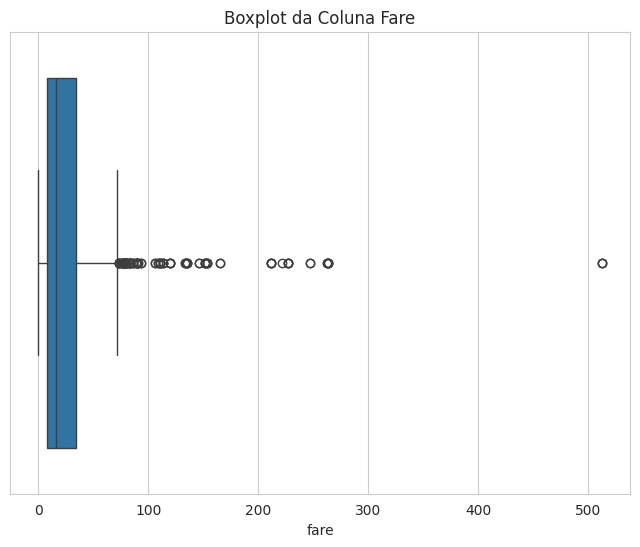

Número de outliers detectados em 'fare' usando IQR: 102
Limites para 'fare': Inferior=-31.17, Superior=73.42


In [ ]:
plt.figure(figsize=(8, 6))
sns.boxplot(x=df_final_limpeza['fare'])
plt.title('Boxplot da Coluna Fare')
plt.show()

Q1 = df_final_limpeza['fare'].quantile(0.25)
Q3 = df_final_limpeza['fare'].quantile(0.75)
IQR = Q3 - Q1

limite_inferior = Q1 - 1.5 * IQR
limite_superior = Q3 + 1.5 * IQR

outliers = df_final_limpeza[(df_final_limpeza['fare'] < limite_inferior) | (df_final_limpeza['fare'] > limite_superior)]
print(f"Número de outliers detectados em 'fare' usando IQR: {len(outliers)}")
print(f"Limites para 'fare': Inferior={limite_inferior:.2f}, Superior={limite_superior:.2f}")

# Para este notebook, não vamos remover os outliers, mas em um projeto real,
# a decisão dependeria da análise (ex: são erros ou valores extremos válidos?).
# Poderíamos, por exemplo, aplicar 'capping' (substituir outliers pelos limites):
# df_final_limpeza['fare_capped'] = np.where(df_final_limpeza['fare'] > limite_superior, limite_superior,
#                                            np.where(df_final_limpeza['fare'] < limite_inferior, limite_inferior, df_final_limpeza['fare']))

## 3. Transformação de Dados

### 3.1 Normalização e Padronização

Colunas numéricas como 'age' e 'fare'.

In [ ]:
df_transformado = df_final_limpeza.copy()

# Padronização (Z-Score) para 'age'
scaler_age = StandardScaler()
df_transformado['age_scaled'] = scaler_age.fit_transform(df_transformado[['age']])

# Normalização (Min-Max) para 'fare'
scaler_fare = MinMaxScaler()
df_transformado['fare_scaled'] = scaler_fare.fit_transform(df_transformado[['fare']])

print("DataFrame com colunas 'age' e 'fare' escaladas:")
print(df_transformado[['age', 'age_scaled', 'fare', 'fare_scaled']].head())

print("\nEstatísticas de 'age_scaled' e 'fare_scaled':")
print(df_transformado[['age', 'age_scaled', 'fare', 'fare_scaled']].describe())

DataFrame com colunas 'age' e 'fare' escaladas:
    age  age_scaled     fare  fare_scaled
0  22.0   -0.551060   7.2500     0.014151
1  38.0    0.611945  71.2833     0.139136
2  26.0   -0.260308   7.9250     0.015469
3  35.0    0.393881  53.1000     0.103644
4  35.0    0.393881   8.0500     0.015713

Estatísticas de 'age_scaled' e 'fare_scaled':
              age    age_scaled        fare  fare_scaled
count  775.000000  7.750000e+02  775.000000   775.000000
mean    29.581187  2.521281e-16   34.878403     0.068078
std     13.766359  1.000646e+00   52.408474     0.102295
min      0.420000 -2.119661e+00    0.000000     0.000000
25%     21.000000 -6.237473e-01    8.050000     0.015713
50%     28.000000 -1.149330e-01   15.900000     0.031035
75%     36.000000  4.665691e-01   34.197900     0.066750
max     80.000000  3.664831e+00  512.329200     1.000000


### 3.2 Discretização (Binning)

Discretização coluna 'age' em faixas etárias.

In [ ]:
# Discretização de 'age' em 5 faixas de igual frequência (quantile)
discretizer = KBinsDiscretizer(n_bins=5, encode='ordinal', strategy='quantile', subsample=None) # subsample=None para evitar warning
df_transformado['age_binned_quantile'] = discretizer.fit_transform(df_transformado[['age']])

# Discretização de 'age' em 5 faixas de igual largura (uniform)
discretizer_uniform = KBinsDiscretizer(n_bins=5, encode='ordinal', strategy='uniform', subsample=None)
df_transformado['age_binned_uniform'] = discretizer_uniform.fit_transform(df_transformado[['age']])

print("Contagem de valores nas faixas etárias (quantile):")
print(df_transformado['age_binned_quantile'].value_counts().sort_index())

print("\nContagem de valores nas faixas etárias (uniform):")
print(df_transformado['age_binned_uniform'].value_counts().sort_index())

Contagem de valores nas faixas etárias (quantile):
age_binned_quantile
0.0    135
1.0    165
2.0    159
3.0    156
4.0    160
Name: count, dtype: int64

Contagem de valores nas faixas etárias (uniform):
age_binned_uniform
0.0     99
1.0    417
2.0    181
3.0     67
4.0     11
Name: count, dtype: int64


### 3.3 Feature Engineering

Novos atributos a partir dos existentes.

In [ ]:
# Criar 'family_size' a partir de 'sibsp' e 'parch'
df_transformado['family_size'] = df_transformado['sibsp'] + df_transformado['parch'] + 1 # +1 para incluir a própria pessoa

# Criar 'is_alone'
df_transformado['is_alone'] = (df_transformado['family_size'] == 1).astype(int)

print("DataFrame com 'family_size' e 'is_alone':")
print(df_transformado[['sibsp', 'parch', 'family_size', 'is_alone']].head())

DataFrame com 'family_size' e 'is_alone':
   sibsp  parch  family_size  is_alone
0      1      0            2         0
1      1      0            2         0
2      0      0            1         1
3      1      0            2         0
4      0      0            1         1


### 3.4 Codificação de Variáveis Categóricas (One-Hot Encoding)

Muitos algoritmos de ML exigem que as entradas sejam numéricas. Vamos aplicar One-Hot Encoding em 'sex', 'embarked' e 'class'.

In [ ]:
# Selecionar colunas categóricas para One-Hot Encoding
# 'pclass' é ordinal, pode ser tratada como numérica ou categórica - vamos incluí-la aqui para demonstração do OHE
cols_categoricas = ['sex', 'embarked', 'class', 'who', 'adult_male', 'pclass']

# Aplicar OneHotEncoder
# Usaremos pd.get_dummies para simplicidade, que é similar ao OneHotEncoder
df_encoded = pd.get_dummies(df_transformado, columns=cols_categoricas, drop_first=True) # drop_first=True para evitar multicolinearidade

print("DataFrame após One-Hot Encoding (primeiras colunas e linhas):")
print(df_encoded.head())

DataFrame após One-Hot Encoding (primeiras colunas e linhas):
   survived   age  sibsp  parch     fare  alone  age_scaled  fare_scaled  \
0         0  22.0      1      0   7.2500  False   -0.551060     0.014151   
1         1  38.0      1      0  71.2833  False    0.611945     0.139136   
2         1  26.0      0      0   7.9250   True   -0.260308     0.015469   
3         1  35.0      1      0  53.1000  False    0.393881     0.103644   
4         0  35.0      0      0   8.0500   True    0.393881     0.015713   

   age_binned_quantile  age_binned_uniform  ...  sex_male  embarked_Q  \
0                  1.0                 1.0  ...      True       False   
1                  3.0                 2.0  ...     False       False   
2                  1.0                 1.0  ...     False       False   
3                  3.0                 2.0  ...     False       False   
4                  3.0                 2.0  ...      True       False   

   embarked_S  class_Second  class_Third  

## 4. Redução de Dados

### 4.1 Seleção de Atributos (Feature Selection)

DataFrame `df_encoded` que agora só tem atributos numéricos (ou booleanos que o Pandas trata como 0/1). A variável alvo será 'survived'.

In [ ]:
# Separar atributos (X) e alvo (y)
X = df_encoded.drop('survived', axis=1)
y = df_encoded['survived']

# 4.1.1 VarianceThreshold: remover atributos com baixa variância
selector_var = VarianceThreshold(threshold=0.01) # Remove atributos com variância < 0.01 (quase constantes)
X_var_selected = selector_var.fit_transform(X)
print(f"Shape original de X: {X.shape}")
print(f"Shape de X após VarianceThreshold: {X_var_selected.shape}")
# Para ver quais colunas foram mantidas:
# print(X.columns[selector_var.get_support()])

# 4.1.2 SelectKBest: selecionar os K melhores atributos
# Usaremos f_classif (ANOVA F-value) pois 'survived' é categórico e temos atributos numéricos.
# Se todos os atributos fossem categóricos (após discretização, por exemplo) e o alvo também, poderíamos usar chi2.
num_features_to_select = 10
selector_kbest = SelectKBest(score_func=f_classif, k=num_features_to_select)
X_kbest_selected = selector_kbest.fit_transform(X, y)
print(f"\nShape de X após SelectKBest: {X_kbest_selected.shape}")

# Ver os scores e as colunas selecionadas
feature_scores = pd.DataFrame({'Feature': X.columns, 'Score': selector_kbest.scores_})
print("\nScores dos atributos (f_classif):")
print(feature_scores.sort_values(by='Score', ascending=False).head(num_features_to_select))

# Colunas selecionadas pelo SelectKBest
selected_features_kbest = X.columns[selector_kbest.get_support()]
print(f"\nColunas selecionadas pelo SelectKBest: {selected_features_kbest.tolist()}")

Shape original de X: (775, 21)
Shape de X após VarianceThreshold: (775, 21)

Shape de X após SelectKBest: (775, 10)

Scores dos atributos (f_classif):
            Feature       Score
18  adult_male_True  300.623983
16          who_man  300.623983
11         sex_male  280.679750
17        who_woman  232.510531
15      class_Third   89.998104
20         pclass_3   89.998104
3              fare   50.292755
6       fare_scaled   50.292755
4             alone   24.917289
10         is_alone   24.917289

Colunas selecionadas pelo SelectKBest: ['fare', 'alone', 'fare_scaled', 'is_alone', 'sex_male', 'class_Third', 'who_man', 'who_woman', 'adult_male_True', 'pclass_3']


### 4.2 Análise de Componentes Principais (PCA)

PCA é uma técnica de extração de atributos que cria novos atributos (componentes principais) não correlacionados.
É importante aplicar PCA em dados escalados.

Shape de X após PCA: (775, 5)

Variância explicada por cada componente principal:
[0.26925214 0.20732243 0.12667931 0.12278933 0.09027571]
Total de variância explicada pelos 5 componentes: 0.8163


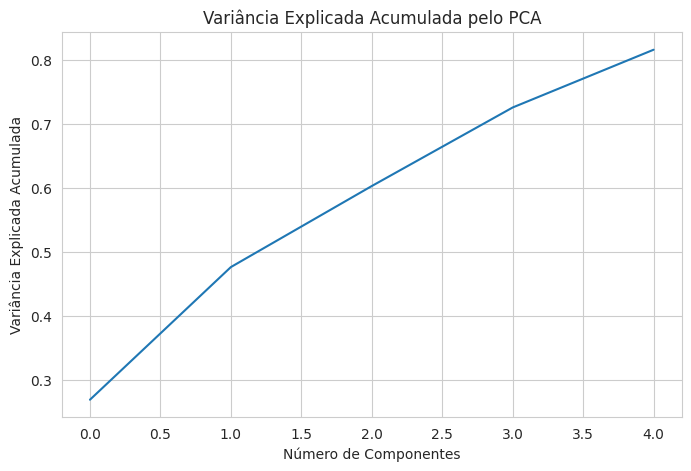


Shape de X após PCA com 95% de variância explicada: (775, 9)
Número de componentes para 95% de variância: 9


In [ ]:
# Usaremos os dados X originais (após encoding, antes da seleção de atributos) e vamos escalá-los primeiro
scaler_pca = StandardScaler()
X_scaled_pca = scaler_pca.fit_transform(X)

# Aplicar PCA para reduzir para, por exemplo, 5 componentes
n_components_pca = 5
pca = PCA(n_components=n_components_pca)
X_pca = pca.fit_transform(X_scaled_pca)

print(f"Shape de X após PCA: {X_pca.shape}")

# Variância explicada por cada componente
print("\nVariância explicada por cada componente principal:")
print(pca.explained_variance_ratio_)
print(f"Total de variância explicada pelos {n_components_pca} componentes: {np.sum(pca.explained_variance_ratio_):.4f}")

# Plotar a variância explicada acumulada
plt.figure(figsize=(8, 5))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Número de Componentes')
plt.ylabel('Variância Explicada Acumulada')
plt.title('Variância Explicada Acumulada pelo PCA')
plt.grid(True)
plt.show()

# Para escolher o número de componentes para reter uma certa porcentagem da variância (ex: 95%)
pca_95 = PCA(n_components=0.95) # Retém componentes que explicam 95% da variância
X_pca_95 = pca_95.fit_transform(X_scaled_pca)
print(f"\nShape de X após PCA com 95% de variância explicada: {X_pca_95.shape}")
print(f"Número de componentes para 95% de variância: {pca_95.n_components_}")

## 5. Discussão

- O pré-processamento é uma etapa importante e muitas vezes demorada em projetos de Mineração de Dados.
- A escolha das técnicas depende do dataset e do algoritmo de mineração que será usado posteriormente.
- É importante aplicar transformações aprendidas no conjunto de treino também no conjunto de teste (e em novos dados) para evitar data leakage e garantir consistência. Pipelines do Scikit-learn são muito úteis para isso.